<a href="https://colab.research.google.com/github/ilanb1/IR2rgb-project/blob/main/ir_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing libraries:


In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import imageio
import time
from IPython import display

mounting to google drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_height = 798
image_width = 1182
images_path = '/content/drive/MyDrive/IR dataset/IR project/new data set'

training_ds = tf.keras.utils.image_dataset_from_directory(
    directory = images_path,
    labels=None,
    label_mode=None,
    batch_size=None,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=119,
    validation_split=0.1,
    subset="training",
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory = images_path,
    labels=None,
    label_mode=None,
    batch_size=None,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=119,
    validation_split=0.1,
    subset="validation",
)

Found 477 files belonging to 1 classes.
Using 430 files for training.
Found 477 files belonging to 1 classes.
Using 47 files for validation.


image shape: (798, 1182, 3)
image max value: 255.0, min value: 0.0
image data type: <dtype: 'float32'>


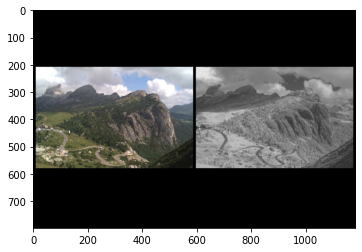

In [4]:
image = list(training_ds.take(1))[0]

print(f"image shape: {image.shape}")
print(f"image max value: {np.max(image)}, min value: {np.min(image)}")
print(f"image data type: {image.dtype}")

plt.imshow(tf.cast(image,"int64"))

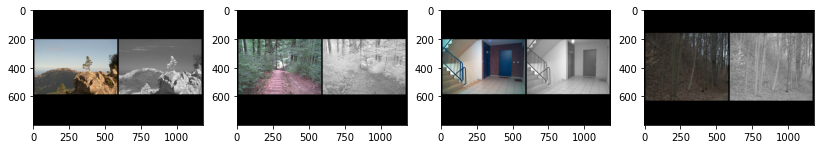

In [5]:
fig, arr = plt.subplots(1, 4, figsize=(14, 10))

for index, image in enumerate(training_ds.take(4)):
  arr[index].imshow(tf.cast(image,"int64"))

In [6]:
# The training set consist of 430 images
BUFFER_SIZE = 430
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

def split_images(image):
  rgb = image[202:585, 10:586, :]
  IR = image[202:585, 596:1172, :]
  # Convert both images to float32 tensors
  rgb = tf.cast(rgb, tf.float32)
  IR = tf.cast(IR, tf.float32)

  return IR , rgb

def show_images(real , IR):
  real = real * 0.5 + 0.5
  IR = IR * 0.5 + 0.5
  fig, arr = plt.subplots(1, 2, figsize=(14, 10))
  arr[0].imshow(real)
  arr[0].set_title('RGB Image')
  arr[1].imshow(IR, cmap="gray")
  arr[1].set_title('IR Image')

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [7]:
def load_image_train(image_file):
  input_image, real_image = split_images(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  input_image = tf.reshape(input_image[...,0],[IMG_HEIGHT, IMG_WIDTH,1])
  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = split_images(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  input_image = tf.reshape(input_image[...,0],[IMG_HEIGHT, IMG_WIDTH,1])
  return input_image, real_image

In [8]:

training_ds = training_ds.map(load_image_train)
#training_ds = training_ds.cache()
training_ds = training_ds.shuffle(BUFFER_SIZE)
training_ds = training_ds.batch(BATCH_SIZE)

validation_ds = validation_ds.map(load_image_test)
#validation_ds = validation_ds.cache()
validation_ds = validation_ds.batch(BATCH_SIZE)

shape of rgb image: (1, 256, 256, 3)
shape of IR image: (1, 256, 256, 1)
rgb image; max value: 1.0 , min value: -0.9686274528503418
IR image; max value: 1.0 , min value: -0.4901960492134094


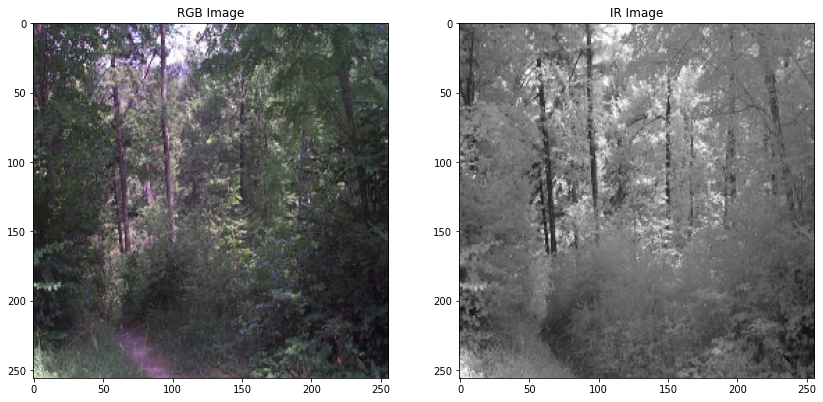

In [9]:
for IR , rgb in training_ds.take(1):
  print(f"shape of rgb image: {rgb.shape}")
  print(f"shape of IR image: {IR.shape}")
  print(f"rgb image; max value: {np.max(rgb)} , min value: {np.min(rgb)}")
  print(f"IR image; max value: {np.max(IR)} , min value: {np.min(IR)}")
  show_images(tf.squeeze(rgb), tf.squeeze(IR))

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [11]:
test_image = IR
#test_image= tf.reshape(test_image , [1, 256, 256 ,1])
down_model = downsample(3, 4)
down_result = down_model(test_image)
print (down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


In [12]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1]) #to match our images

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
generator = Generator()
#generator.summary()

In [14]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

(1, 256, 256, 1)


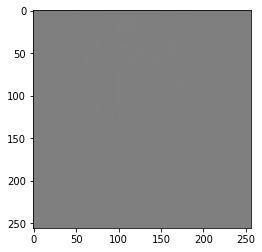

In [15]:

print(test_image.shape)                      
gen_output = generator(test_image  , training=False)
plt.imshow(tf.cast(gen_output[0], tf.float32)*0.5+0.5)

In [16]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [17]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image') #IR image got 1 channel only
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [18]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

(1, 30, 30, 1)


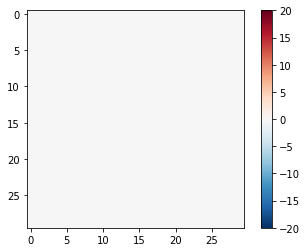

In [19]:
disc_out = discriminator([test_image, gen_output], training=False)
print(disc_out.shape)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
checkpoint_dir = '/content/drive/MyDrive/IR dataset/IR project/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  rgb = tar[0] * 0.5 + 0.5
  IR = tf.squeeze(test_input) * 0.5 +0.5
  generated = prediction[0] * 0.5 + 0.5
  
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  plt.subplot(1,3,1)
  plt.title("IR image (Input)")
  plt.imshow(IR, cmap="gray")
  plt.axis('off')
  
  plt.subplot(1,3,2)
  plt.title('Real RGB Image (Ground Truth)')
  plt.imshow(rgb)
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.title('Generated RGB Image (Prediction)')
  plt.imshow(generated)
  plt.axis('off')
  
  plt.show()

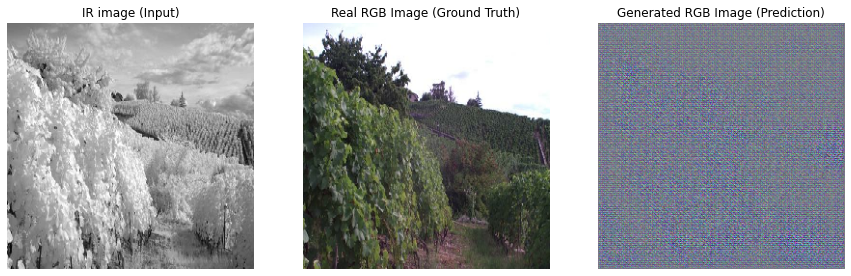

In [24]:
for example_input, example_target in training_ds.take(1):
  generate_images(generator, example_input, example_target)

In [25]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  # with summary_writer.as_default():
  #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
  #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
  #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
  #   tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [26]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 173.65 sec



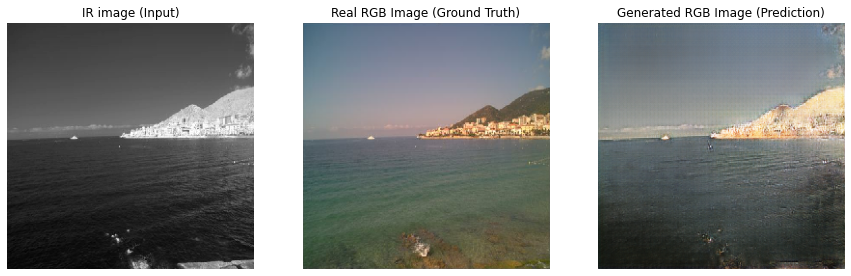

Step: 9k
....................................................................................................

In [35]:
fit(training_ds, validation_ds, steps=10000)

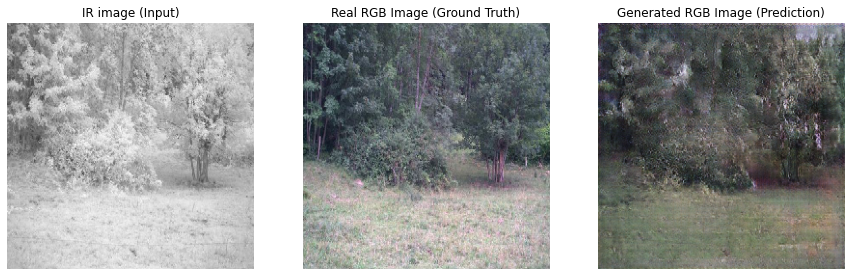

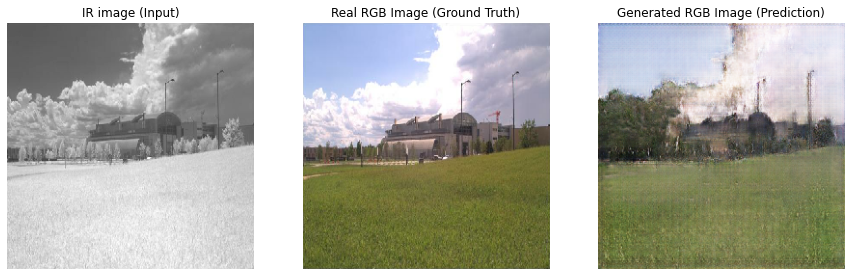

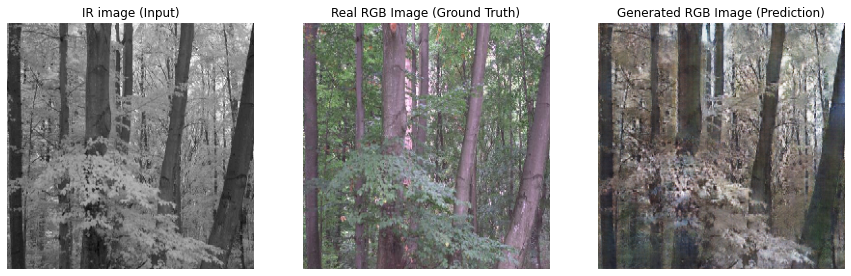

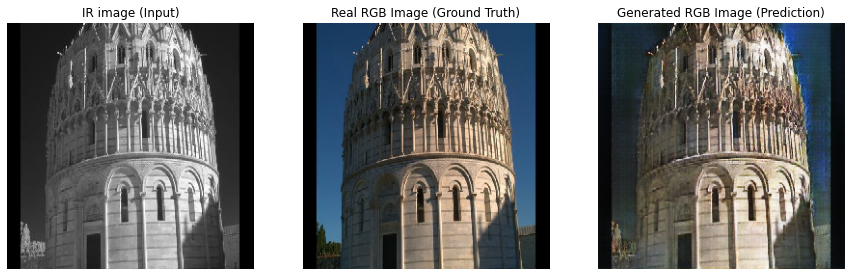

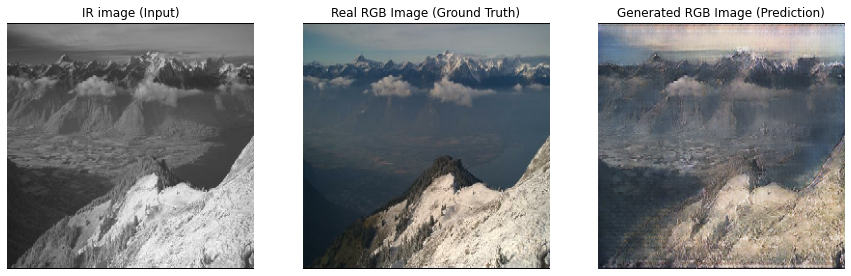

In [45]:
for example_input, example_target in validation_ds.take(5):
  generate_images(generator, example_input, example_target)

In [42]:
# save the progress
checkpoint.save(file_prefix=checkpoint_prefix)

'/content/drive/MyDrive/IR dataset/IR project/checkpoints/ckpt-10'

In [33]:
#load checkpoint
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
